In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

In [55]:
df_train_val = pd.read_csv('data/train_val_split.csv')
df_test = pd.read_csv('data/test_split.csv')
df_full = pd.concat([df_train_val, df_test])

In [56]:
print(df_full.dtypes)
print('\n', df_full.isna().sum())

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

 Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [57]:
numerical_vars = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_vars = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease', 'FastingBS']

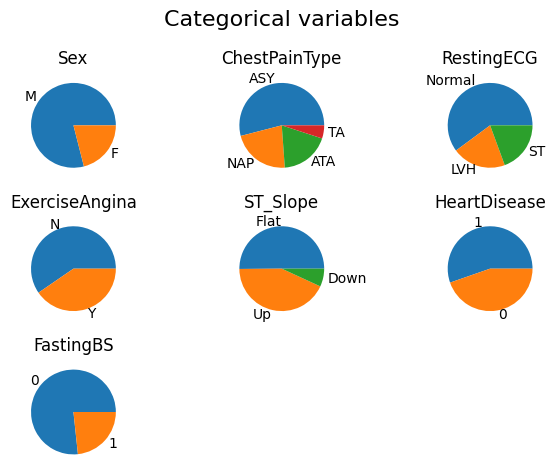

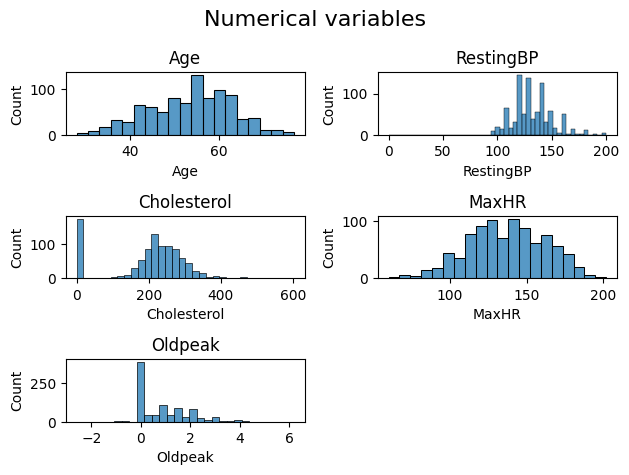

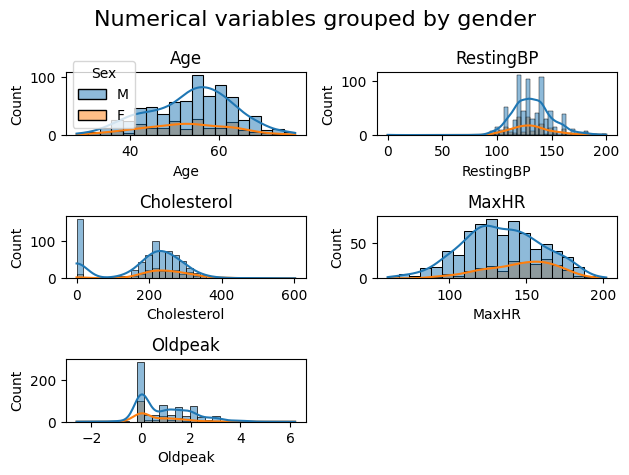

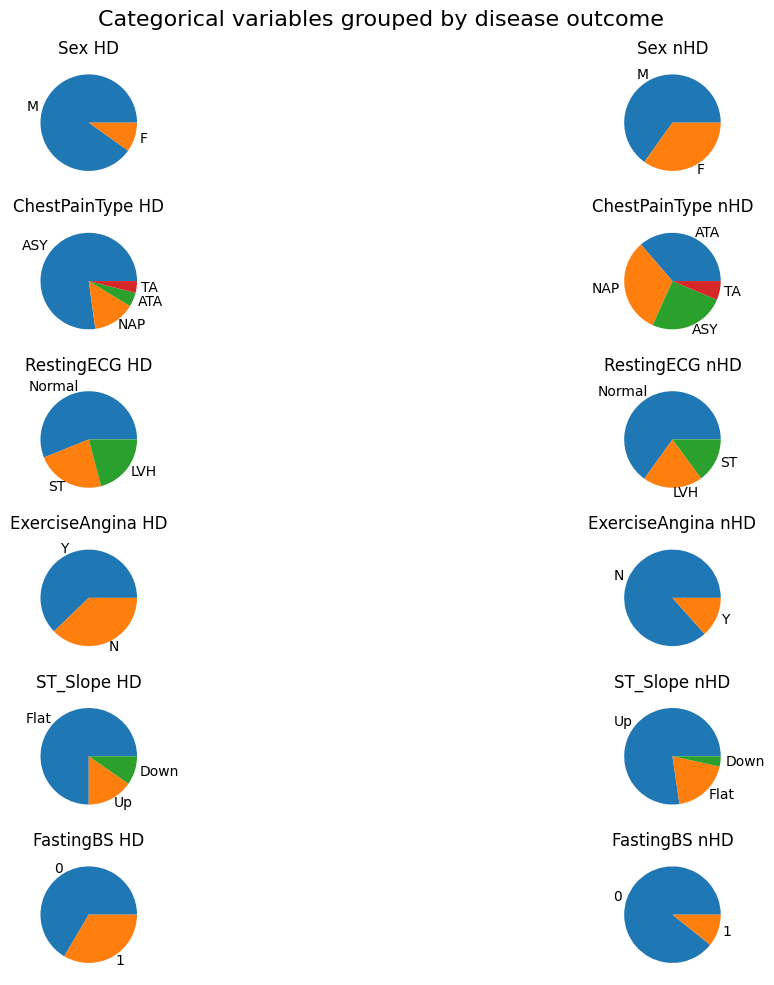

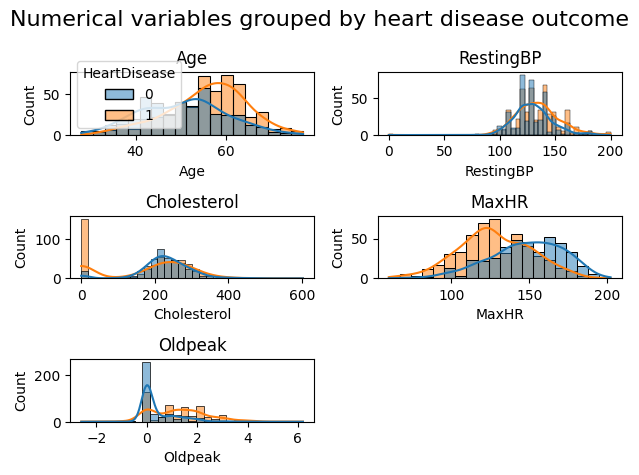

Maximum Age: 77
Minimum Age: 28

Maximum RestingBP: 200
Minimum RestingBP: 0

Maximum Cholesterol: 603
Minimum Cholesterol: 0

Maximum MaxHR: 202
Minimum MaxHR: 60

Maximum Oldpeak: 6.2
Minimum Oldpeak: -2.6



In [58]:
# Plotting categorical variables
fig, axs = plt.subplots(3, 3)
for k, col in enumerate(categorical_vars):
    i = int(k / 3)
    j = int(k - i*3) % 3
    
    axs[i, j].set_title(col)
    counts = df_full[col].value_counts()
    axs[i, j].pie(counts, labels=counts.index)

axs[2, 1].set_visible(False)
axs[2, 2].set_visible(False)


fig.suptitle('Categorical variables', fontsize=16)
plt.tight_layout()
plt.show()

# Plotting numerical variables
fit, axs = plt.subplots(3, 2)
for k, col in enumerate(numerical_vars):
    i = int(k / 2)
    j = int(k - i*2) % 2
    
    axs[i, j].set_title(col)
    sns.histplot(data=df_full, x=col, ax=axs[i, j])

axs[2, 1].set_visible(False)

plt.suptitle('Numerical variables', fontsize=16)
plt.tight_layout()
plt.show()

# Plotting numerical variables grouped by gender
fit, axs = plt.subplots(3, 2)
for k, col in enumerate(numerical_vars):
    i = int(k / 2)
    j = int(k - i*2) % 2
    
    axs[i, j].set_title(col)
    sns.histplot(data=df_full, x=col, hue='Sex', kde=True, ax=axs[i, j])
    if k != 0:
        axs[i, j].legend_.remove()

axs[2, 1].set_visible(False)

plt.suptitle('Numerical variables grouped by gender', fontsize=16)
plt.tight_layout()
plt.show()

# Plotting categorical variables grouped by disease outcome
non_hd_cat_vars = categorical_vars.copy()
non_hd_cat_vars.remove('HeartDisease')
disease_df_full = df_full[df_full['HeartDisease'] == 1]
non_disease_df_full = df_full[df_full['HeartDisease'] == 0]

fig, axs = plt.subplots(6, 2, figsize=(16, 10))
for i, col in enumerate(non_hd_cat_vars):
    disease_counts = disease_df_full[col].value_counts()
    non_disease_counts = non_disease_df_full[col].value_counts()
    
    axs[i, 0].set_title(f'{col} HD')
    axs[i, 1].set_title(f'{col} nHD')
    axs[i, 0].pie(disease_counts, labels=disease_counts.index)
    axs[i, 1].pie(non_disease_counts, labels=non_disease_counts.index)

fig.suptitle('Categorical variables grouped by disease outcome', fontsize=16)
plt.tight_layout()
plt.show()

# Plotting numerical variables grouped by heart disease outcome
fit, axs = plt.subplots(3, 2)
for k, col in enumerate(numerical_vars):
    i = int(k / 2)
    j = int(k - i*2) % 2
    
    axs[i, j].set_title(col)
    sns.histplot(data=df_full, x=col, hue='HeartDisease', kde=True, ax=axs[i, j])
    if k != 0:
        axs[i, j].legend_.remove()

axs[2, 1].set_visible(False)

plt.suptitle('Numerical variables grouped by heart disease outcome', fontsize=16)
plt.tight_layout()
plt.show()

for col in numerical_vars:
    print(f'Maximum {col}: {df_full[col].max()}\nMinimum {col}: {df_full[col].min()}\n')

## Findings about the data
- There are no missing values
- The categorical variables look good but there are much more men than women
- Age looks good
- There are 0s in RestingBP
- There are 0s in Cholesterol
- MaxHR looks good
- Oldpeak looks good I think

### Differences between genders
- Not much
- Maybe in MaxHR

### Differences between disease outccome
- Everything looks different
- RestingBP is pretty close
- There are also major differences in categorical variables

## Interesting findings
- The ChestPainType is odd. You would not expect that ASY shows the highest correlation with the disease

## Need to be fixed
- RestingBP
- Cholesterol
- Converting categories to numbers, they are not nominal (outside of gender) so we don't use one-hot encoding
    - ChestPainType: ASY < NAP < ATA < TA
    - RestingECG: Normal < ST < LVH
    - ST_Slope: Up < Flat < Down

In [59]:
def convert_category(df):    
    df['Sex'] = df['Sex'].replace(['F', 'M'], [0, 1])
    #df['Sex_M'] = (df['Sex'] == 'M').astype(int)
    #df['Sex_F'] = (df['Sex'] == 'F').astype(int)
    #df.drop('Sex', axis=1, inplace=True)
    df['ChestPainType'] = df['ChestPainType'].replace(['ASY', 'NAP', 'ATA', 'TA'], [0, 1, 2, 3])
    df['RestingECG'] = df['RestingECG'].replace(['Normal', 'ST', 'LVH'], [0, 1, 2])
    df['ExerciseAngina'] = df['ExerciseAngina'].replace(['N', 'Y'], [0, 1])
    df['ST_Slope'] = df['ST_Slope'].replace(['Up', 'Flat', 'Down'], [0, 1, 2])
    df = df.infer_objects(False)

In [60]:
def insert_nans(df):
    df.loc[df['RestingBP'] == 0, 'RestingBP'] = np.nan
    df.loc[df['Cholesterol'] == 0, 'Cholesterol'] = np.nan

In [61]:
# Converting categorical variables to numericals and inserting NAs
convert_category(df_full)
insert_nans(df_full)
convert_category(df_train_val)
insert_nans(df_train_val)
convert_category(df_test)
insert_nans(df_test)

/var/folders/jr/_lkl4v697jlbznhrwjmhr1t00000gn/T/ipykernel_62304/1569616699.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Sex'] = df['Sex'].replace(['F', 'M'], [0, 1])
/var/folders/jr/_lkl4v697jlbznhrwjmhr1t00000gn/T/ipykernel_62304/1569616699.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['ChestPainType'] = df['ChestPainType'].replace(['ASY', 'NAP', 'ATA', 'TA'], [0, 1, 2, 3])
/var/folders/jr/_lkl4v697jlbznhrwjmhr1t00000gn/T/ipykernel_62304/1569616699.py:7: FutureWarning: Downcasting behavior in `replace` is dep

In [62]:
df_full

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,2,140.0,289.0,0,0,172,0,0.0,0,0
1,37,1,2,130.0,283.0,0,1,98,0,0.0,0,0
2,48,0,0,138.0,214.0,0,0,108,1,1.5,1,1
3,54,1,1,150.0,195.0,0,0,122,0,0.0,0,0
4,39,1,1,120.0,339.0,0,0,170,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
179,57,1,0,140.0,192.0,0,0,148,0,0.4,1,0
180,52,1,2,120.0,284.0,0,0,118,0,0.0,0,0
181,38,1,1,138.0,175.0,0,0,173,0,0.0,0,0
182,48,1,0,130.0,256.0,1,2,150,1,0.0,0,1


In [63]:
# Creating numpy arrays from the data sets
X_train_val = df_train_val.drop('HeartDisease', axis=1).to_numpy()
y_train_val = df_train_val['HeartDisease'].to_numpy()
X_test = df_test.drop('HeartDisease', axis=1).to_numpy()
y_test = df_test['HeartDisease'].to_numpy()

In [64]:
# Filling the missing values with KNN imputer
imputer = KNNImputer()
imputer.fit(X_train_val)
X_train_val = imputer.transform(X_train_val)
X_test = imputer.transform(X_test)

In [65]:
# Creating final data frames for saving for future use
df_train_val_filled = df_train_val.copy()
df_train_val_filled[df_train_val_filled.columns.drop('HeartDisease')] = X_train_val
df_test_filled = df_test.copy()
df_test_filled[df_test_filled.columns.drop('HeartDisease')] = X_test

In [66]:
# Saving the final data frames
df_train_val_filled.to_parquet('data/train_val.parquet')
df_test_filled.to_parquet('data/test.parquet')

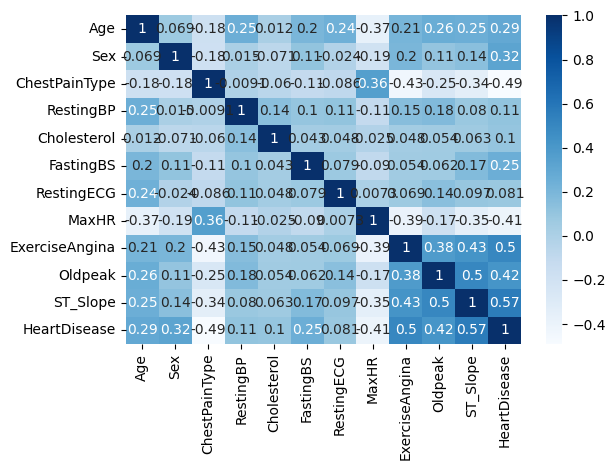

In [67]:
matrix = df_train_val_filled.corr()
# plotting correlation matrix
sns.heatmap(matrix, cmap='Blues', annot=True)

plt.tight_layout()
plt.show()

